# Using an Ensemble model and Transformer - Fixed Length

In this notebook, we combine two previously trained transformer models, one on the sequences containing ATG and another on the sequences bit containing ATG, to predict the MRL of a 5'UTR.

In [64]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
from sklearn import preprocessing

import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams['agg.path.chunksize'] = 0
mpl.rcParams.update( mpl.rc_params() )
plt.rcParams.update({'font.size': 18})
#plt.rcParams.update({'text.usetex': True})
plt.rcParams.update({'text.latex.preamble': 'bold'})
plt.rc('font', family='serif')

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers
from tensorflow.keras.layers import Embedding, Layer, Dense, Dropout, MultiHeadAttention, LayerNormalization, Input, GlobalAveragePooling1D
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
import keras
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

from sklearn.metrics import r2_score

import json

## Useful Functions

In [65]:
def split_atg(X1,X,y):
    label_atg,atg,label_no_atg,no_atg = [], [], [], []
    for i in range(len(X)):
        seq = ""
        for j in range(len(X[1])-1):
            seq += X[i][j][0]
        seq += X[i][-1]
        if "ATG" in seq:
            atg.append(X1[i])
            label_atg.append(y[i])
        else:
            no_atg.append(X1[i])
            label_no_atg.append(y[i])
    return np.array(label_atg),np.array(atg),np.array(label_no_atg),np.array(no_atg) 
    

def split_seq_into_words(n, seqs):
    return np.array([" ".join([str(seqs[i][j:j+n]) for j in range(0,len(seqs[i])-n+1)]) for i in range(len(seqs))])
    

def r2(x,y):
    return 1 - sum((x-y)**2)/sum((x-np.mean(x))**2)
            
    

## Importing data

In [66]:
data_path = "Data/GSM3130435_egfp_unmod_1_PREPROCESSED.csv.gz"
df = pd.read_csv(data_path, compression='gzip')


In [67]:
df.head()

,Unnamed: 0,utr,0,1,2,3,4,5,6,7,...,r9,r10,r11,r12,r13,rl,Selection,one-hot encoding,Length,scaled_rl
0,120605,CCACTCGATTAACATGTTAACAACATACTCGTCCGGCCGATCAGCG...,0.000137,0.000109,0.000057,0.000033,0.000015,0.000016,0.000009,0.000009,...,0.019283,0.033252,0.033252,0.027581,0.035877,3.039939,Selected Data,"[[0, 1, 0, 0], [0, 1, 0, 0], [1, 0, 0, 0], [0,...",50,-2.130922
1,11605,CAAATCATGTGCAGCCCTGGCGACCGTACTGCGGTACAAGAAAGTA...,0.000067,0.000070,0.000065,0.000048,0.000023,0.000020,0.000011,0.000011,...,0.024241,0.039457,0.039457,0.039840,0.038785,3.895109,Selected Data,"[[0, 1, 0, 0], [1, 0, 0, 0], [1, 0, 0, 0], [1,...",50,-1.600332
2,128224,GTTATACTAGAAGAAACTTGAGATTATGGAGCAGTCCGTCAAGGAC...,0.000088,0.000081,0.000059,0.000035,0.000017,0.000016,0.000009,0.000009,...,0.021591,0.028353,0.028353,0.028963,0.041985,3.334524,Selected Data,"[[0, 0, 1, 0], [0, 0, 0, 1], [0, 0, 0, 1], [1,...",50,-1.948147
3,239107,CTTAGACAAAAACAACGCGCTTTCCAGTATGCGGAGCCTTGACGGT...,0.000078,0.000071,0.000060,0.000038,0.000025,0.000016,0.000010,0.000009,...,0.026617,0.038302,0.038302,0.032788,0.031043,3.575082,Selected Data,"[[0, 1, 0, 0], [0, 0, 0, 1], [0, 0, 0, 1], [1,...",50,-1.798893
4,59082,GTATCAAATCACGGCCAACCCGACGGAGTACCCCGCGTCGATGGTC...,0.000044,0.000045,0.000050,0.000051,0.000033,0.000026,0.000015,0.000012,...,0.033080,0.051449,0.051449,0.046052,0.036447,4.593712,Selected Data,"[[0, 0, 1, 0], [0, 0, 0, 1], [1, 0, 0, 0], [0,...",50,-1.166885


In [68]:
rl = df["rl"].values
utr = df["utr"].values

In [69]:
sentences = split_seq_into_words(5, utr)

In [70]:
label_atg,atg,label_no_atg,no_atg = split_atg(sentences, sentences, rl)

In [71]:
max_len = (len(sentences[0])+1)//6

In [72]:
with open("no_atg_token2.json", "r") as file:
    no_atg_str = json.load(file)
    
tokenizer_no_atg = keras.preprocessing.text.tokenizer_from_json(no_atg_str)

In [73]:
with open("atg_token.json", "r") as file:
    atg_str = json.load(file)
    
tokenizer_atg = keras.preprocessing.text.tokenizer_from_json(atg_str)

In [74]:
padding_type = 'post'
trunc_type = 'post'

In [75]:
model_atg = keras.models.load_model('model_transformer_mrl_fit_atg2', custom_objects = {"r2_score":r2_score})
model_no_atg = keras.models.load_model('model_transformer_mrl_fit_no_atg', custom_objects = {"r2_score":r2_score})

In [76]:
scaler = preprocessing.StandardScaler()

In [77]:
u = scaler.fit_transform(rl.reshape(-1,1))

## Building Ensemble Model

In [78]:
def ensemble_transformer_atg_model(X, atg_in):
    if atg_in == True:
        train_sequences = tokenizer_atg.texts_to_sequences(X)
        X = pad_sequences(train_sequences, maxlen=max_len, padding=padding_type, truncating=trunc_type)
        predictions_atg = model_atg.predict(X).reshape(-1)
        return scaler.inverse_transform(predictions_atg.reshape(-1,1)).reshape(-1)
    else:
        train_sequences = tokenizer_no_atg.texts_to_sequences(X)
        X = pad_sequences(train_sequences, maxlen=max_len, padding=padding_type, truncating=trunc_type)
        predictions_no_atg = model_no_atg.predict(X).reshape(-1)
        return predictions_no_atg.reshape(-1)

## Testing the model

In [79]:
atg_sample = atg[:15000]
y_atg_sample = label_atg[:15000]

In [80]:
no_atg_sample = no_atg[:15000]
y_no_atg_sample = label_no_atg[:15000]

In [81]:
atg_pred = ensemble_transformer_atg_model(atg_sample, True)

469/469 [==============================] - 31s 65ms/step


In [82]:
no_atg_pred = ensemble_transformer_atg_model(no_atg_sample, False)

469/469 [==============================] - 31s 66ms/step


C:\Users\user\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


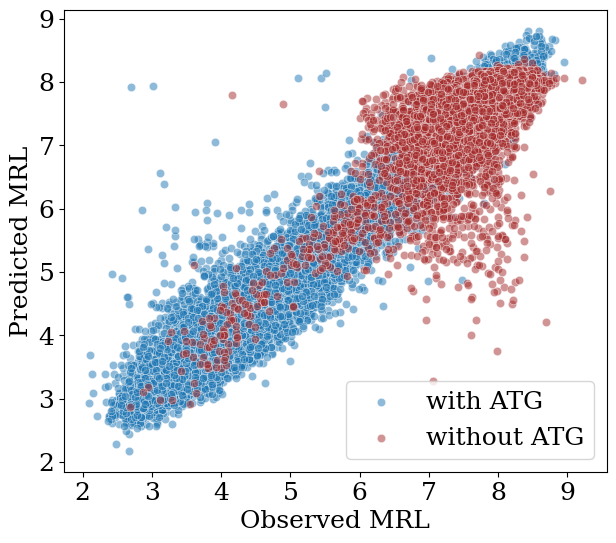

In [83]:
fig = plt.figure(figsize = (7,6))
sns.scatterplot(y_atg_sample, atg_pred ,linewidth = 0.5, alpha=0.5, label = 'with ATG')
ax = sns.scatterplot(y_no_atg_sample, no_atg_pred ,
                linewidth = 0.5, alpha=0.5, label = 'without ATG', color = 'brown', legend = 'auto')

ax.set(xlabel = 'Observed MRL', ylabel = 'Predicted MRL')
plt.xticks([2,3,4,5,6,7,8,9])
plt.savefig("Transformer_ensemble_atg_best.pdf", bbox_inches = "tight")
plt.show()

In [84]:
r2_score(np.concatenate((y_no_atg_sample, y_atg_sample), axis = None), 
         np.concatenate((no_atg_pred, atg_pred), axis = None))

0.9462734845189613